In [42]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg

In [43]:
data_path = "data_cleaned_feature_31.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds'],
      dtype='object')


(149885, 31)

In [44]:
# drop duplicates
data = data.drop_duplicates()
data.shape

(149885, 31)

In [45]:
data.select_dtypes(include=['int64', 'float64'])

,video_view_count,video_like_count,video_comment_count,channel_view_count,channel_subscriber_count,channel_video_count,engagement_rate,video_duration_seconds
0,156272.0,4615.0,238.0,46473647,321000,207,0.031055,774.0
1,2148646.0,222346.0,11225.0,6395292,158000,61,0.108706,317.0
2,1106491.0,44317.0,2406.0,2807917957,8880000,1612,0.042226,2223.0
3,1185486.0,25373.0,2664.0,122939495,389000,635,0.023650,1297.0
4,69035.0,4346.0,125.0,85074466,436000,1429,0.064764,1269.0
...,...,...,...,...,...,...,...,...
149880,8548359.0,378107.0,3089.0,5592638348,12500000,1019,0.044593,24.0
149881,22553412.0,623924.0,7208.0,6331232520,8890000,480,0.027984,15.0
149882,63090147.0,2451904.0,3598.0,33506017412,44400000,3136,0.038921,15.0
149883,765386.0,27876.0,716.0,42201127,379000,809,0.037356,6566.0


In [46]:
def time_to_seconds(time_str):
    days, time_part = time_str.split(" days ")
    days = int(days)
    h, m, s = map(int, time_part.split(":"))
    total_seconds = days * 86400 + h * 3600 + m * 60 + s
    return total_seconds

data['time_to_trend_difference_seconds'] = data['time_difference'].apply(time_to_seconds)
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['is_weekend'] = pd.to_datetime(data['video_published_at']).dt.weekday >= 5

In [47]:
columns_for_fa = [ 'video_view_count', 'video_like_count', 'video_comment_count',
    'channel_view_count', 
    'channel_video_count', 'time_to_trend_difference_seconds',
    'video_duration_seconds']
fa_data = data[columns_for_fa].apply(pd.to_numeric, errors='coerce').dropna()
scaler = StandardScaler()
factor_data_standardized = scaler.fit_transform(fa_data)
kmo_all, kmo_model = calculate_kmo(factor_data_standardized)
print(f"KMO: {kmo_model}")
chi_square_value, p_value = calculate_bartlett_sphericity(factor_data_standardized)
print(f"Bartlett's Test - Chi-Square: {chi_square_value}, p-value: {p_value}")
fa = FactorAnalyzer(n_factors=3, rotation='varimax') 
fa.fit(factor_data_standardized)
eigenvalues, _ = fa.get_eigenvalues()
print(f"Eigenvalues: {eigenvalues}")
loadings = fa.loadings_
print(f"Factor Loadings:\n{loadings}")

KMO: 0.6110047499077821
Bartlett's Test - Chi-Square: 351240.4475798048, p-value: 0.0
Eigenvalues: [2.52114072 1.16899624 1.0289022  0.86363226 0.75901578 0.57420976
 0.08410303]
Factor Loadings:
[[ 0.8371877   0.3400273   0.04817764]
 [ 0.9575172   0.26772918  0.1195129 ]
 [ 0.50401756 -0.15539699 -0.01791814]
 [ 0.31910668  0.22810022  0.46726521]
 [-0.05170046 -0.15197509  0.35839714]
 [ 0.23732967  0.23277888 -0.16727011]
 [-0.02012567 -0.37904892  0.03271162]]


In [48]:
factor_loadings = fa.loadings_
factor_loadings

threshold = 0.4
strong_loadings = np.abs(factor_loadings) > threshold

for i in range(factor_loadings.shape[1]):  
    print(f"Factor {i+1} includes variables: {np.where(strong_loadings[:, i])[0]}")

Factor 1 includes variables: [0 1 2]
Factor 2 includes variables: []
Factor 3 includes variables: [3]


In [49]:
alpha1, ci1 = pg.cronbach_alpha(pd.DataFrame(factor_data_standardized).iloc[:, [0, 1,2]])
print(f"Factor 1 - Cronbach's Alpha: {alpha1}, 95% CI: {ci1}")

Factor 1 - Cronbach's Alpha: 0.7985978898191615, 95% CI: [0.797 0.8  ]


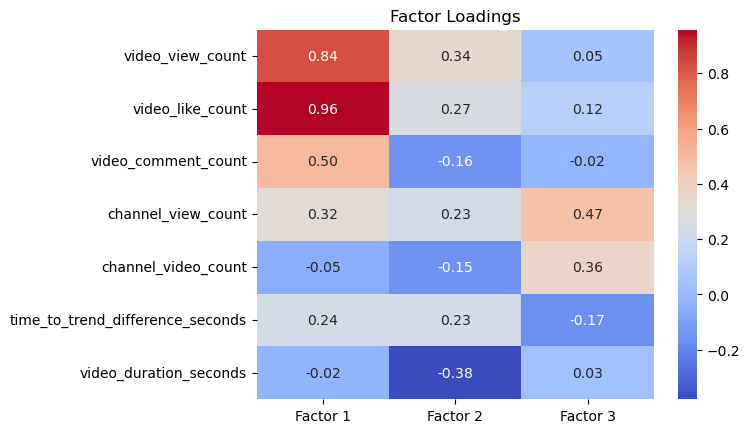

In [50]:
import seaborn as sns
factor_loadings_df = pd.DataFrame(loadings, columns=['Factor 1', 'Factor 2', 'Factor 3'], index=columns_for_fa)
sns.heatmap(factor_loadings_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Factor Loadings')
plt.show()

In [ ]:
data['is_trending'] = data['time_difference'].apply(
    lambda x: 1 if int(x.split(" ")[0]) <= 1 else 0 
)
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
0    135724
1     14161
Name: count, dtype: int64

In [52]:
# do split (" ") and take the first element

data["time_difference_days"] = data["time_difference"].apply(lambda x: int(x.split(" ")[0]))
data["time_difference_days"]

0          5
1         26
2          3
3          3
4          3
          ..
149880    19
149881    10
149882    24
149883     4
149884    18
Name: time_difference_days, Length: 149885, dtype: int64

In [53]:
majority_class = data[data['is_trending'] == 0]
minority_class = data[data['is_trending'] == 1]
# shape
majority_class.shape, minority_class.shape

((135724, 37), (14161, 37))

In [76]:
from sklearn.utils import resample


minority_upsampled = resample(minority_class, 
                              replace=True,     
                              n_samples=int(round(len(majority_class) * 0.3, -2)),  
                              random_state=42)  

data = pd.concat([majority_class, minority_upsampled])
data.is_trending.value_counts()

is_trending
0    135724
1     40700
Name: count, dtype: int64

In [55]:
data['channel_published_at'] = pd.to_datetime(data['channel_published_at'], errors='coerce').dt.tz_localize(None)
data['video_published_at'] = pd.to_datetime(data['video_published_at'], errors='coerce').dt.tz_localize(None)
data['channel_video_channel_publish_difference'] = (data['video_published_at'] - data['channel_published_at']).dt.days
data['channel_video_channel_publish_difference']

0         2939.0
1            NaN
2         3423.0
3            NaN
4            NaN
           ...  
7005         NaN
32731        NaN
132841    4233.0
113650    2567.0
37666     5621.0
Name: channel_video_channel_publish_difference, Length: 176424, dtype: float64

In [56]:
data['channel_published_at']

0        2016-09-23 08:16:40
1                        NaT
2        2015-07-09 18:57:30
3                        NaT
4                        NaT
                 ...        
7005                     NaT
32731                    NaT
132841   2013-04-18 14:39:48
113650   2017-10-24 20:09:02
37666    2009-05-29 14:50:20
Name: channel_published_at, Length: 176424, dtype: datetime64[ns]

In [57]:
data['video_published_at']

0        2024-10-10 16:19:23
1        2024-10-06 17:48:07
2        2024-11-22 16:00:20
3        2024-11-15 18:00:06
4        2024-11-06 21:32:42
                 ...        
7005     2024-11-10 13:01:23
32731    2024-11-13 09:30:08
132841   2024-11-20 02:14:13
113650   2024-11-04 18:02:32
37666    2024-10-19 01:02:13
Name: video_published_at, Length: 176424, dtype: datetime64[ns]

In [58]:
data['channel_video_channel_publish_difference'] = data['channel_video_channel_publish_difference'].fillna(data['channel_video_channel_publish_difference'].mean()) # di ko na alam kung tama to

In [59]:
# import SMOTENN 
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)

In [60]:
data['is_trending'].value_counts()

is_trending
0    135724
1     40700
Name: count, dtype: int64

In [61]:
data['is_weekend'].value_counts()

is_weekend
False    124516
True      51908
Name: count, dtype: int64

In [62]:
features = [
    'video_duration_seconds', 'channel_video_count',
    'video_category_id', 'video_trending_country', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers','channel_video_channel_publish_difference'
]


In [63]:
data.channel_have_hidden_subscribers

0         False
1         False
2         False
3         False
4         False
          ...  
7005      False
32731     False
132841    False
113650    False
37666     False
Name: channel_have_hidden_subscribers, Length: 176424, dtype: bool

In [64]:
# data['is_trending'] = data['time_difference'].apply(
#     lambda x: 1 if int(x.split(" ")[0]) <= 3 else 0
# )

In [65]:
categorical_features = [
    'video_category_id', 'video_trending_country', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference'
]

In [66]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
y = data['is_trending']

In [67]:
X_categorical.shape

(176424, 8)

In [68]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(regression=False)
X_categorical_encoded = encoder.fit_transform(X_categorical, y)

In [69]:
print(X_numerical.isna().sum()) 
print(np.isinf(X_numerical).sum()) 
print(X_numerical.describe())  

video_duration_seconds                      0
channel_video_count                         0
channel_video_channel_publish_difference    0
dtype: int64
video_duration_seconds                      0
channel_video_count                         0
channel_video_channel_publish_difference    0
dtype: int64
       video_duration_seconds  channel_video_count  \
count           176424.000000        176424.000000   
mean              1124.472521          5350.438812   
std               2691.181581         21602.454846   
min                 10.000000             0.000000   
25%                 53.000000           231.000000   
50%                249.000000           709.000000   
75%               1228.000000          1770.000000   
max              42901.000000        540692.000000   

       channel_video_channel_publish_difference  
count                             176424.000000  
mean                                3993.923086  
std                                 1152.396603  
min        

In [70]:
import numpy as np
X = np.hstack((X_numerical, X_categorical_encoded))
X.shape

(176424, 11)

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# smootenn
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

In [72]:
from sklearn.ensemble import RandomForestClassifier
# adjust class weights
# parameters for random_forest classifier

model = RandomForestClassifier(random_state=42,class_weight='balanced')
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [73]:
accuracy = model.score(X_test_scaled, y_test)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9050219165659008


In [74]:
# classification report confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[36671  3935]
 [ 1092 11230]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     40606
           1       0.74      0.91      0.82     12322

    accuracy                           0.91     52928
   macro avg       0.86      0.91      0.88     52928
weighted avg       0.92      0.91      0.91     52928



<Axes: >

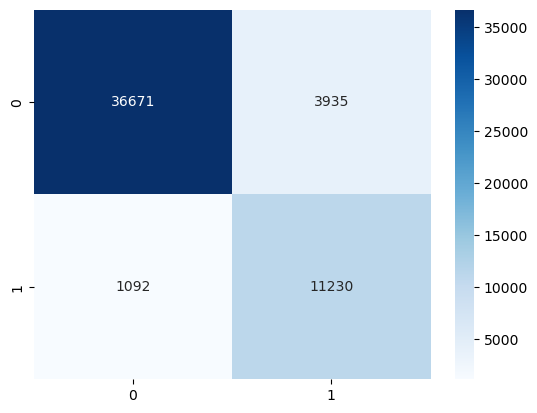

In [75]:
# heatmap confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [39]:
data.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_to_trend_difference_seconds', 'likes_per_view',
       'comments_per_view', 'is_weekend', 'is_trending',
       'time_difference_days', 'channel_video_channel_publish_difference'],
      dtype='object')

In [35]:
importance = model.feature_importances_
feature_importance = pd.DataFrame(importance, index=features, columns=['importance']).sort_values('importance', ascending=False)
feature_importance

,importance
channel_video_count,0.455299
video_duration_seconds,0.289840
video_category_id,0.178292
is_weekend,0.040236
video_trending_country,0.009069
video_definition,0.008931
channel_have_hidden_subscribers,0.008912
channel_country,0.008286
video_dimension,0.001136
video_licensed_content,0.000000


<Figure size 1000x800 with 0 Axes>

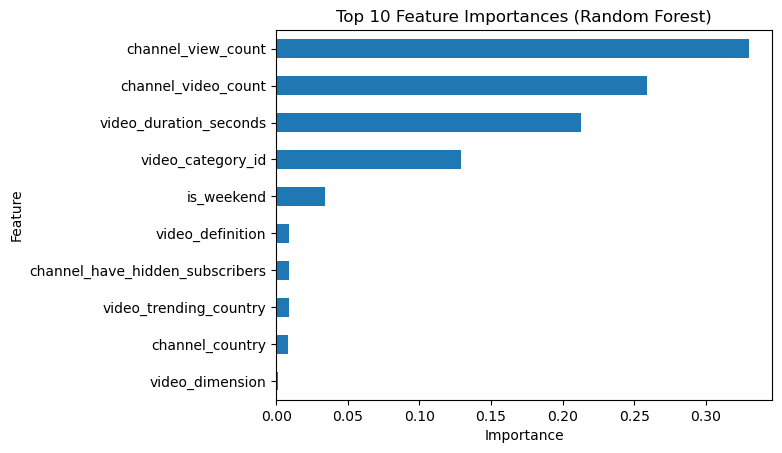

In [36]:
plt.figure(figsize=(10, 8))
feature_importance.head(10).plot(kind='barh', legend=False)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

In [254]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [255]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

In [256]:
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train_tensor))

In [257]:
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [258]:
num_epochs = 100
batch_size = 64


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [259]:
model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.5139
Epoch [20/100], Loss: 0.5357
Epoch [30/100], Loss: 0.4657
Epoch [40/100], Loss: 0.5624
Epoch [50/100], Loss: 0.5226
Epoch [60/100], Loss: 0.4857
Epoch [70/100], Loss: 0.2354
Epoch [80/100], Loss: 0.3308
Epoch [90/100], Loss: 0.5864
Epoch [100/100], Loss: 0.5217


In [261]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, y_pred_classes = torch.max(y_pred, 1)

accuracy = (y_pred_classes == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"Model Accuracy: {accuracy:.4f}")

y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_classes.numpy()
print(confusion_matrix(y_test_np, y_pred_np))
print(classification_report(y_test_np, y_pred_np))

Model Accuracy: 0.7219
[[37522  3010]
 [13981  6575]]
              precision    recall  f1-score   support

           0       0.73      0.93      0.82     40532
           1       0.69      0.32      0.44     20556

    accuracy                           0.72     61088
   macro avg       0.71      0.62      0.63     61088
weighted avg       0.71      0.72      0.69     61088

